In [ ]:
%matplotlib inline

In [262]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from sklearn.neighbors import DistanceMetric
from math import radians
import re
from googletrans import Translator

In [263]:
# Read the directory.csv file into a data frame
starbucks = pd.read_csv('directory.csv')
starbucks= starbucks[['store_name','City', 'State/Province','Country','Longitude', 'Latitude']]


#Create a new column for store count
starbucks['store_count'] = np.ones(starbucks.shape[0]).astype(int).tolist()
starbucks.sample(5)

#Read the country code file into the dateframe.
country_code = pd.read_csv('country_code.csv')
country_code

#Dataframe for the world population
world_population = pd.read_csv('world_population.csv')
world_population = world_population[['country', 'population']]
world_population.loc[world_population.country=='United States']
world_population.sample(5)



,country,population
2,United States,"331,002,651"
181,French Guiana,"298,682"
135,Mongolia,"3,278,290"
34,Ukraine,"43,733,762"
28,Colombia,"50,882,891"


In [264]:
#Merge the starbucks data frame and the country code
starbucks2= pd.merge(starbucks,country_code, left_on='Country', right_on='Two_Letter_Country_Code').drop('Two_Letter_Country_Code', axis=1)
starbucks2.sample(3)

starbucks2.sample(3)

,store_name,City,State/Province,Country,Longitude,Latitude,store_count,Continent_Name,Country_Name
21981,Giant Eagle 1284 Avon Lake,AVON LAKE,OH,US,-81.99,41.49,1,North America,United States of America
13701,Green Valley Crossing - Fairfield,Fairfield,CA,US,-122.14,38.21,1,North America,United States of America
704,Safeway Fort Saskatchewan #846,Fort Saskatchewan,AB,CA,-113.21,53.69,1,North America,Canada


In [ ]:
#Modify the name of some countries, removing 'the, republic of'
country_name = starbucks2['Country_Name'].tolist()

country_name = [country.split(',')[0] for country in country_name]

#Assign the modified values in the country_name column
starbucks2['Country_Name'] = country_name


#Change united states of america to united states
starbucks2['Country_Name']= starbucks2['Country_Name'].apply(lambda x : 'United States' if x=='United States of America' else x)

#Change Russian Federation to Russia
starbucks2['Country_Name']= starbucks2['Country_Name'].apply(lambda x : 'Russia' if x=='Russian Federation' else x)


starbucks2['Country_Name']= starbucks2['Country_Name'].apply(lambda x : 'South Korea' if x=='Korea' else x)

#Change Russian Federation to Russia
starbucks2['Country_Name']= starbucks2['Country_Name'].apply(lambda x : 'Czech Republic' if x=='Czech Republic (Czechia)' else x)


# Change column names to lower case
starbucks2.columns = [x.lower()  for x in starbucks2.columns]


In [ ]:
#Translate some city names in english
translator = Translator()
starbucks2['City']= starbucks2['City'].apply(lambda x : translator.translate(x) )

In [ ]:
#Merge world population data with starbucks data 
starbucks3 = pd.merge(starbucks2, world_population, how='left', left_on='country_name', right_on='country')
starbucks3.drop('country_y', axis=1, inplace=True)

#Rename some columns
starbucks3.rename(columns={'country_x':'code', 'continent_name':'continent', 'country_name':'country'}, inplace=True)



In [ ]:
df= starbucks3.loc[starbucks3.country=='China']
df2= df['city'].unique().tolist()
df2


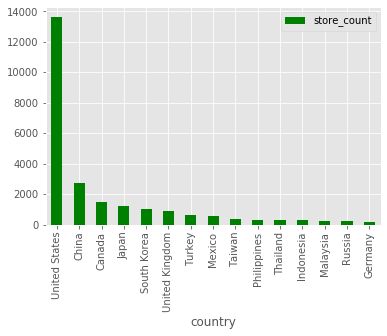

In [106]:
#Top 15 countries in terms of starbucks store count
df_bar= starbucks3[['country','store_count']].groupby('country').sum().sort_values( ascending=False, by='store_count')

#Bar graph
df_bar.head(15).plot.bar(color='g')


In [125]:
# #Remove the comma in the population 78,100 -->78100
pop_df= starbucks3.copy()
pop_df.dropna(axis=0, inplace=True)
pop_df['population']= pop_df['population'].str.replace(',', '').astype(float)
pop_df.sample(2)


,store_name,city,state/province,code,longitude,latitude,store_count,continent,country,population
4062,东莞莞城万科中心店,东莞市,44,CN,113.76,23.02,1,Asia,China,1.439324e+09
7284,Shinjuku Daian Bldg.,Shinjuku-ku,13,JP,139.70,35.69,1,Asia,Japan,1.264765e+08


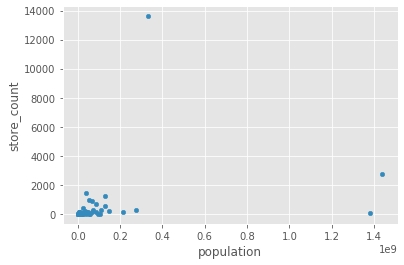

In [127]:
df_scatter= pop_df.groupby(['country', 'population']).agg({'store_count':'sum'}).reset_index()
df_scatter.plot.scatter('population', 'store_count')


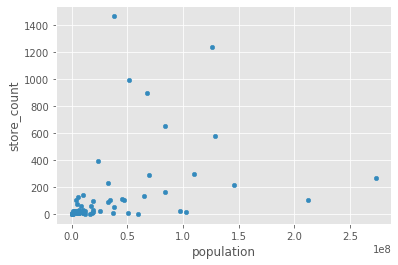

In [128]:
#removing the outliers
df_scatter = df_scatter[['population', 'store_count']]
df_scatter = df_scatter.loc[df_scatter.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
df_scatter.plot.scatter('population', 'store_count')

In [247]:
city_df = starbucks3[['city', 'country', 'store_count', 'longitude', 'latitude']]
city_df = city_df.dropna(axis=0)


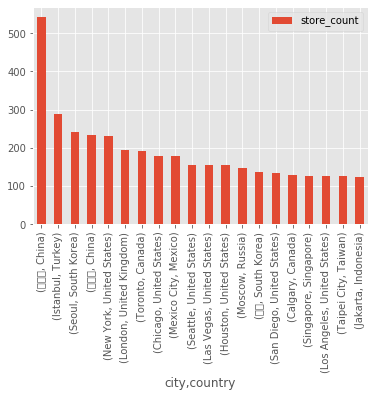

In [248]:
city_bar = city_df.groupby(['city', 'country']).agg({'store_count':'sum'}).sort_values(by='store_count',ascending=False).head(20)
city_bar.plot.bar()


In [218]:
def avg_dist(df):
    
    """
    df: is a pandas dataframe

    Return the average distance of stores in miles
    """

    #Convert lat and lon degrees in radians
    df['latitude'] = np.radians(df['latitude'])
    df['longitude'] = np.radians(df['longitude'])

    #find the haversine distance
    dist = DistanceMetric.get_metric('haversine')

    #an array of distance of neighboring stores in miles
    array =dist.pairwise(df[['latitude','longitude']].to_numpy())*3798

    return np.mean(array[0])



In [251]:
city1 =city_bar.reset_index().loc[:,['city','country']].to_numpy()

In [252]:
city_list =[]
distance_list =[]

for ele in city1:
    city=ele[0]
    country= ele[1]
    
    city2 = city_df.loc[(city_df.city==city) & (city_df.country==country)]
    distance = avg_dist(city2)
    
    city_list.append(city)
    distance_list.append(distance)
    


C:\Users\randy\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\randy\anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [253]:

distance_df =pd.DataFrame({'city': pd.Series(city_list), 'avg_dist':pd.Series(distance_list)})
distance_df
    

,city,avg_dist
0,上海市,6.580064
1,Istanbul,12.080779
2,Seoul,10.185766
3,北京市,7.992574
4,New York,2.485534
5,London,6.196099
6,Toronto,3.275323
7,Chicago,4.345767
8,Mexico City,10.114578
9,Seattle,5.680730


In [204]:
city1 =city_bar.reset_index().loc[:,['city','country']].to_numpy()
city1


array([['上海市', 'China'],
       ['Istanbul', 'Turkey'],
       ['Seoul', 'South Korea'],
       ['北京市', 'China'],
       ['New York', 'United States'],
       ['London', 'United Kingdom'],
       ['Toronto', 'Canada'],
       ['Chicago', 'United States'],
       ['Mexico City', 'Mexico'],
       ['Seattle', 'United States'],
       ['Las Vegas', 'United States'],
       ['Houston', 'United States'],
       ['Moscow', 'Russia'],
       ['서울', 'South Korea'],
       ['San Diego', 'United States'],
       ['Calgary', 'Canada'],
       ['Singapore', 'Singapore']], dtype=object)

In [234]:
seoul = city_df.loc[(city_df.city=='Seoul') & (city_df.country=='South Korea')]

seoul['latitude'] = np.radians(seoul['latitude'])
seoul['longitude'] = np.radians(seoul['longitude'])

#find the haversine distance
dist = DistanceMetric.get_metric('haversine')

#an array of distance of stores
array =dist.pairwise(seoul[['latitude','longitude']].to_numpy())*3798

array[0]



C:\Users\randy\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\randy\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([ 0.        ,  7.58044291,  2.20218711,  9.99853379,  6.71150918,
        7.01379373,  9.8012066 ,  7.46402927, 12.08163482,  9.90106328,
       11.50135221, 10.79537528,  7.58841979,  7.46003008,  9.14328251,
        7.00803908,  7.901447  ,  2.6515042 , 10.70464355,  5.78544043,
        9.52300401, 35.54194784,  8.06470113,  5.41608319, 31.32068554,
       13.7237405 ,  5.78544043,  9.06630959,  6.17051018,  6.25986841,
        7.31053849,  5.78544043,  8.69049645,  4.57312328, 19.41557544,
       21.88123613,  4.94961516,  7.13020172,  5.78544043,  7.58841979,
        6.05768263,  9.36949721, 25.71738824,  8.7603732 ,  7.9545126 ,
        7.61199999, 13.53489447, 34.63600948,  5.78544043,  3.73151829,
        9.06630959, 20.65661774,  9.00896633,  9.98264579,  6.62386553,
        8.23718755, 42.4993412 ,  9.51734211,  9.06630959,  4.11794615,
        6.62386553, 33.39446069, 23.43881904, 13.7237405 ,  7.34969114,
        4.49797245, 11.96042152, 21.67637652, 34.61758183,  4.90

In [ ]:
city_df = starbucks.loc[(starbucks.City=='London') & (starbucks.Country=='GB')]
city_df

city_bar

